In [1]:
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# トランザクションのリスト
trans_list = []
# ItemIDとアイテム名の辞書（キー：ItemID、値：アイテム名）
item_dict = {}
# ItemID辞書（キー：アイテム名、値：ItemID）
itemid_dict = {}
# アイテム辞書に新規アイテムを追加する時のItemID
item_id = 0
# トランザクションID
tid = 0
# ファイル名
file = 'data/Groceries.csv'

with open(file, mode="r") as f:
    reader = csv.reader(f)
    # 各行は row に読み込まれる
    for row in reader:
        # 各行のアイテムが item に入る
        for item in row:
            # 辞書に item があるならば itemID を取り出す
            itemID = itemid_dict.get(item)
            # None が戻り値ならば、辞書に item が無いので、辞書に追加
            if itemID is None:
                itemID = 'I' + str(item_id)
                itemid_dict[item] = itemID
                item_dict[itemID] = item
                item_id = item_id + 1
            #print(tid, itemID, item)
            # アイテムごとのトランザクションをリストに追加
            trans_list.append([tid, itemID])
        tid = tid + 1
        # デバッグ用：5行読み込みで終了
        #if (tid >= 5):
        #    break

# 確認
#print(trans_list)

# pandas DataFrame に変換、確認
df = pd.DataFrame(trans_list, columns=['TID', 'ItemID'])
df

,TID,ItemID
0,0,I0
1,0,I1
2,0,I2
3,0,I3
4,1,I4
...,...,...
43362,9834,I32
43363,9834,I4
43364,9834,I11
43365,9834,I135


<hr>

### 相関ルール生成のプログラム

In [2]:
# TIDを重複排除のため集合に変換
all_trans = set(df.TID)
# |D| : トランザクション数
all_trans_len = len(all_trans)

# 1つのitemについて、そのitemを含むTIDの集合を辞書で管理
count_dict = {}
# 全てのitemについて、そのitemを含むTIDの集合をtrans_setに追加
for item in df.ItemID.unique():
    count_dict[item] = set(df[df['ItemID'] == item].TID)

In [3]:
from functools import reduce
from itertools import combinations

# サポートカウントの計算
def support_count(item_set):
    trans_set = []
    # item_setの各itemについて、そのitemを含むTIDの集合をtrans_setに追加
    for item in item_set:
        trans_set.append(count_dict[item])
    # trans_set の確認用
    # print(trans_set)
    # 全itemを含むTIDは、各itemを含むTIDの集合の積集合の要素数
    return len(reduce(lambda a, x: a & x, trans_set, all_trans))

# サポートの計算
def support(itemset):
    return support_count(itemset) / all_trans_len

# コンフィデンスの計算
def confidence(itemset_A, itemset_B):
    return support_count(itemset_A | itemset_B) / support_count(itemset_A)

# Generate_Candidates(L_{k-1}, k, min_sup_count)
def generate_candidates(L, k, min_sup_count):
    Ck = []
    for l1 in L:
        for l2 in L:
            # listのインデックスは 0 始まり
            if l1[0:k - 2] == l2[0:k - 2] and l1[k - 2] < l2[k - 2]:
                c = sorted(list(set(l1) | set(l2)))
                # print('k={}: {} | {} = {}'.format(k, l1, l2, c))
                for i in combinations(c, k - 1):
                    if support_count(i) < min_sup_count:
                        break
                else:   # 上のbreak文が実行されなかった場合
                    Ck.append(c)
    return Ck

# Apriori アルゴリズムの処理
def apriori():
    # 全てのアイテム
    all_items = sorted(list(set(df.ItemID)))

    # 頻出アイテムセットの集合を格納するdict型変数
    L = {}

    # L1 ← 1つのアイテムからなる頻出アイテムセットの集合
    L[1] = [[i] for i in all_items if support_count({i}) >= min_sup_count]
    # print('L1 = ', L[1])

    # k ← 2
    k = 2

    while L[k - 1] != []:
        Lk = []
        Ck = generate_candidates(L[k - 1], k, min_sup_count)
        for c in Ck:
            # print('{} {}'.format(c, support_count(c)))
            if support_count(c) >= min_sup_count:
                Lk.append(c)
        L[k] = Lk
        # print('L{} = {}'.format(k, L[k]))
        k = k + 1
    
    # 和集合
    L_union = []
    for ln in L.values():
        for l in ln:
            L_union.append(l)

    return L_union

# 相関ルールの生成
def create_assoc_rules(l, v=0):
    # 相関ルールの初期化
    assoc_rule = []
    # 全ての真部分集合 all_s のリストを初期化
    all_s = []
    # 全ての真部分集合 all_s の作成
    for n in range(1, len(l)):
        for i in combinations(l, n):
            all_s.append(list(i))
    # all_sの確認
    #print('all_s = {}'.format(all_s))

    # lのサポートカウント
    l_support_count = support_count(l)

    # 各真部分集合についてコンフィデンスを計算
    for s in all_s:
        # コンフィデンス(s ⇒ (l-s))
        s_support_count = support_count(s)
        cnfd = l_support_count / s_support_count
        # 確認用
        if (v > 0):
            print('{} {}/{}={}'.format(s, l_support_count, s_support_count, cnfd))
        # 最小コンフィデンス以上のルールを相関ルールに追加
        if cnfd >= min_confidence:
            # (l-s)
            l_s = [i for i in l if i not in s]
            sprt = l_support_count / all_trans_len
            lift = cnfd / (support_count(l_s) / all_trans_len)
            assoc_rule.append([s, l_s, sprt, cnfd, lift])

    return assoc_rule

# 全ての相関ルールの生成
def create_all_assoc_rules():
    # 相関ルールの初期化
    assoc_rules = []
    # Aprioriアルゴリズムで求めた全ての頻出アイテムセットから相関ルールを生成
    for l in apriori():
        rules = create_assoc_rules(l)
        if rules != []:
            for r in rules:
                assoc_rules.append(r)

    return pd.DataFrame(assoc_rules, columns=['L', 'R', 'support', 'confidence', 'lift'])

<hr>

In [4]:
# 最小サポート: 2.5%
min_sup = 0.02
# 最小コンフィデンス: 30%
min_confidence = 0.3

# 最小サポートカウント
min_sup_count = all_trans_len * min_sup
# 表示
print('all_trans_len:', all_trans_len)
print('min_sup_count:', min_sup_count)

# 相関ルールの生成
print('全ての相関ルールの生成:')
df_rules = create_all_assoc_rules()
# 確認
# - リフト値でソート（降順）
df_rules.sort_values('lift', ascending=False).head(10)

all_trans_len: 9835
min_sup_count: 196.70000000000002
全ての相関ルールの生成:


,L,R,support,confidence,lift
33,"[I11, I7]",[I42],0.023183,0.309783,2.842082
34,"[I42, I7]",[I11],0.023183,0.474012,2.449770
4,[I42],[I11],0.047382,0.434701,2.246605
7,[I60],[I11],0.028876,0.402837,2.081924
36,"[I5, I7]",[I11],0.022267,0.397459,2.054131
35,"[I11, I5]",[I7],0.022267,0.512881,2.007235
11,[I14],[I7],0.027555,0.497248,1.946053
6,[I58],[I11],0.021657,0.375661,1.941476
16,[I26],[I7],0.026131,0.490458,1.919481
32,"[I11, I42]",[I7],0.023183,0.489270,1.914833


In [5]:
# networkx のインポート
import networkx as nx

# 対象とする関係をリフト値上位10に限定
a = df_rules.sort_values('lift', ascending=False).reset_index().head(10)

# 親ノードの抽出
ant = a['L'].values
ant = [tuple(x) for x in ant]

# 子ノードの抽出
con = a['R'].values
con = [tuple(x) for x in con]

# 全ノードのリストアップ
both = ant + con
both = list(set(both))

# 結果の一部確認
print(both)

# 乱数の種
random_seed = 123

[('I11', 'I7'), ('I11', 'I42'), ('I60',), ('I11',), ('I58',), ('I5', 'I7'), ('I42',), ('I7',), ('I42', 'I7'), ('I26',), ('I14',), ('I11', 'I5')]


In [6]:
# 関係グラフの初期化
G = nx.DiGraph()

# ノードの追加
for n in both:
  G.add_node(n)

# エッジの追加
for i in range(len(a)):
    item = a.loc[i]
    ant = tuple(item['L'])
    con = tuple(item['R'])
    G.add_edge(ant, con)

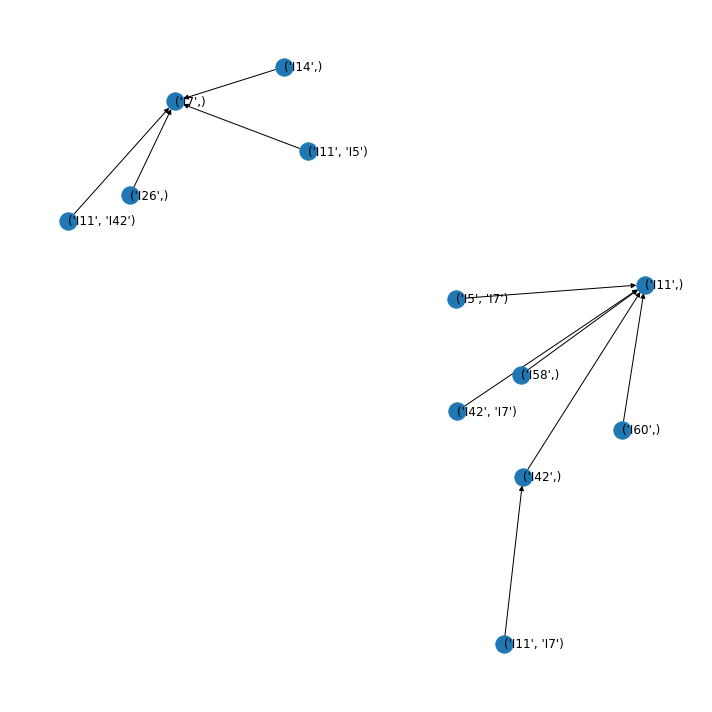

In [7]:
# グラフ描画
pos = nx.spring_layout(G, k=0.6, seed=random_seed)

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,
    horizontalalignment='left', 
    verticalalignment='center')
plt.axis('off')
plt.tight_layout()
plt.show()